In [1]:
import numpy as np
from matplotlib import pyplot as plt
import torch
from scene_synthesis.datasets.nuScenes import NuScenesDataset
from scene_synthesis.datasets.utils import collate_test
from scene_synthesis.networks.autoregressive_transformer import AutoregressiveTransformer

def to_numpy(data: dict):
    for k in data:
        if isinstance(data[k], torch.Tensor):
            data[k] = data[k].squeeze()
            if not data[k].shape:
                data[k] = data[k].item()
            else:
                data[k] = data[k].numpy()
        elif isinstance(data[k], dict):
            to_numpy(data[k])


In [15]:
plt.ion()
dataset = NuScenesDataset("/media/yifanlin/My Passport/data/nuScene-processed/train")
axes_limit = 40
cat2color = {1: 'red', 2: 'blue', 3: 'green'}
model = AutoregressiveTransformer()
model.load_state_dict(torch.load('./ckpts/08-07-22:21:01'))


<All keys matched successfully>

In [25]:
data = dataset[10]
input_data, length = collate_test([data], keep='random')
for k in data:
    data[k] = input_data[k].squeeze(0).numpy()


In [26]:
condition = {
    "category": 3,  # int
}


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


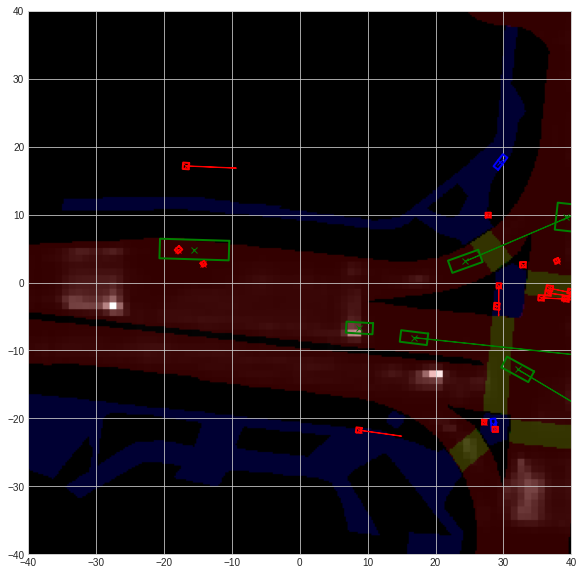

In [27]:
for _ in range(1):
    preds, probs = model.generate(input_data, length, condition, n_sample=5)
    to_numpy(preds)
    category = preds['category']
    if category != 0:
        data['category'] = np.concatenate([data['category'], np.array([preds['category']])], axis=0)
        data['location'] = np.concatenate([data['location'], preds['location'].reshape(1, -1)], axis=0)
        data['bbox'] = np.concatenate([data['bbox'], np.concatenate([preds['wl'], np.array([preds['theta']])], axis=0).reshape(1, -1)], axis=0)
        data['velocity'] = np.concatenate([data['velocity'], np.array([[preds['s'] * preds['moving'], preds['omega']]])], axis=0)
        idx = list(range(len(data['category'])))
        idx.sort(key=lambda i: (-data['location'][i, 1], data['location'][i, 0]))
        for k in ['category', 'location', 'bbox', 'velocity']:
            data[k] = data[k][idx]
        input_data = {}
        input_data['category'] = torch.tensor(data['category'])
        for k in ['location', 'bbox', 'velocity', 'map']:
            input_data[k] = torch.tensor(data[k], dtype=torch.float)
        input_data, length = collate_test([input_data], keep='all', append=True)

        _, ax = plt.subplots(figsize=(10, 10))
        map_layers = np.stack(data['map'][:3], axis=-1) * 0.2
        prob_map = probs['location'].log_prob(torch.tensor(np.arange(6400))).reshape(80, 80).numpy()
        prob_map = np.exp(prob_map)
        prob_map = np.kron(prob_map, np.ones((4, 4)))
        prob_map /= prob_map.sum()
        map_layers += prob_map[..., None] / prob_map.max()
        ax.imshow(map_layers, extent=[-axes_limit, axes_limit, -axes_limit, axes_limit])
        for i in range(length.item()):
            if data['category'][i] != 0:
                color = cat2color[data['category'][i]]
                loc = data['location'][i]
                ax.plot(loc[0], loc[1], 'x', color=color)
                w, l, theta = data['bbox'][i]
                corners = np.array([[l / 2, w / 2],
                                    [-l / 2, w / 2],
                                    [-l / 2, -w / 2],
                                    [l / 2, -w / 2],
                                    [l / 2, w / 2]])
                rotation = np.array([[np.cos(theta), np.sin(theta)],
                                     [-np.sin(theta), np.cos(theta)]])
                corners = np.dot(corners, rotation) + loc
                ax.plot(corners[:, 0], corners[:, 1], color=color, linewidth=2)
                speed, omega = data['velocity'][i]
                rotation = np.array([[np.cos(omega), np.sin(omega)],
                                     [-np.sin(omega), np.cos(omega)]])
                velocity = np.dot(np.array([speed, 0]), rotation)
                ax.arrow(loc[0], loc[1], velocity[0] * 5, velocity[1] * 5, color=color, width=0.05)
        ax.set_xlim([-axes_limit, axes_limit])
        ax.set_ylim([-axes_limit, axes_limit])


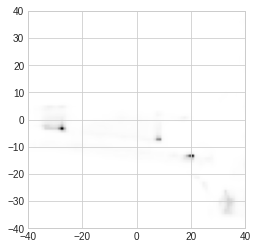

In [28]:
prob_map = probs['location'].log_prob(torch.tensor(np.arange(6400))).reshape(80, 80).numpy()
prob_map = np.exp(prob_map)
plt.imshow(prob_map, extent=[-axes_limit, axes_limit, -axes_limit, axes_limit])

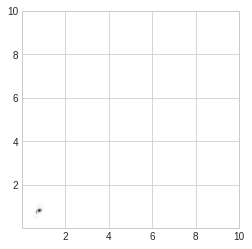

In [20]:
y, x = torch.meshgrid(torch.linspace(10, 0.01, 200), torch.linspace(0.01, 10, 200))
grids = torch.stack([x, y], dim=-1)
prob_map_wl = torch.exp(probs['wl'].log_prob(grids))
plt.imshow(prob_map_wl, extent=[0.01, 10, 0.01, 10])

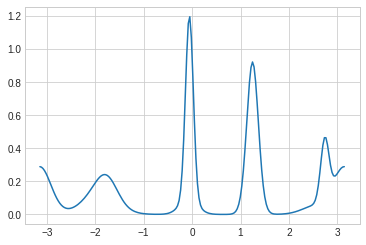

In [29]:
x = torch.linspace(-np.pi, np.pi, 200)
y = torch.exp(probs['theta'].log_prob(x[..., None]))
plt.plot(x, y)

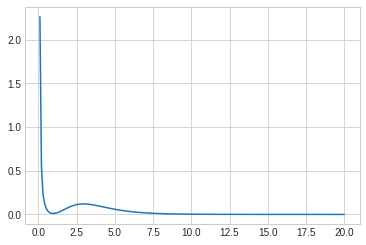

In [13]:
x = torch.linspace(0.1, 20, 200)
y = torch.exp(probs['s'].log_prob(x[..., None]))
plt.plot(x, y)

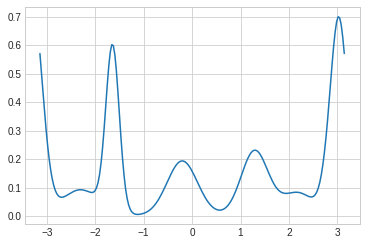

In [14]:
x = torch.linspace(-np.pi, np.pi, 200)
y = torch.exp(probs['omega'].log_prob(x[..., None]))
plt.plot(x, y)

In [95]:
import torch
from torch import nn
from torch.autograd import grad
from torch.distributions import Normal
from torch.optim import Adam


class MLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.body = nn.Sequential(
            nn.Linear(1, 64),
            nn.Softplus(),
            nn.Linear(64, 64),
            nn.Softplus(),
            nn.Linear(64, 64),
            nn.Softplus(),
            nn.Linear(64, 64),
            nn.Softplus(),
            nn.Linear(64, 64),
            nn.Softplus(),
            nn.Linear(64, 1),
        )

    def forward(self, x):
        return self.body(x)


mu = -2.
sigma = 0.5
target = Normal(torch.tensor([mu]), torch.tensor([sigma]))

In [96]:
model = MLP()
optimzer = Adam(model.parameters(), lr=1e-3)
n_sample = 5

In [97]:
for iters in range(4000):
    loss_sample = []
    optimzer.zero_grad()
    for _ in range(n_sample):
        x = nn.Parameter(target.sample())
        log_prob = model(x)
        score = grad(log_prob, x, grad_outputs=torch.ones(x.shape), create_graph=True, retain_graph=True)[0]
        dscore = grad(score, x, create_graph=True, retain_graph=True)[0]
        loss_sample.append(dscore + 0.5 * score**2)
    loss = torch.stack(loss_sample).mean()
    print(iters, loss.item())
    loss.backward()
    optimzer.step()

0 -0.00016467514797113836
1 -0.001162869855761528
2 -0.0023178423289209604
3 -0.0036303475499153137
4 -0.005625334568321705
5 -0.007280223071575165
6 -0.009297214448451996
7 -0.012293150648474693
8 -0.016494592651724815
9 -0.021529564633965492
10 -0.028138136491179466
11 -0.030735153704881668
12 -0.04264913499355316
13 -0.050761591643095016
14 -0.0672600120306015
15 -0.0646003857254982
16 -0.08488737046718597
17 -0.10259250551462173
18 -0.12461602687835693
19 -0.13540753722190857
20 -0.11402913182973862
21 -0.2177715003490448
22 -0.2848518192768097
23 -0.350082129240036
24 -0.2805883288383484
25 -0.3343431055545807
26 -0.41752439737319946
27 -0.5225378274917603
28 -0.6774219274520874
29 -0.7506579160690308
30 -0.5883989334106445
31 -1.1583064794540405
32 -1.1443023681640625
33 -1.107649803161621
34 -0.3112106919288635
35 -1.9471867084503174
36 -1.4286949634552002
37 -1.8988916873931885
38 -2.2275772094726562
39 -2.456638813018799
40 -2.9845612049102783
41 0.8127037286758423
42 -1.09906

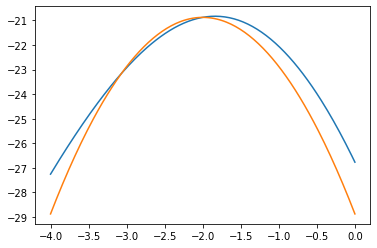

In [115]:
from matplotlib import pyplot as plt
import numpy as np


with torch.no_grad():
    x = torch.linspace(-4, 0, 200)
    y = model(x[..., None]).squeeze()
    plt.plot(x, y)
x = np.linspace(-4, 0, 200)
y = -np.log(np.sqrt(2 * np.pi) * sigma) - (x - mu)**2 / (2 * sigma**2) - 20.65
plt.plot(x, y)
plt.show()

In [171]:
x = torch.randn(1000, 1)
eps = 0.01
for _ in range(400):
    x = nn.Parameter(x)
    log_prob = model(x)
    score = grad(log_prob, x, grad_outputs=torch.ones(x.shape), create_graph=True, retain_graph=True)[0]
    x = x + eps * score + (2 * eps)**0.5 * torch.randn_like(x)
    x = x.detach()

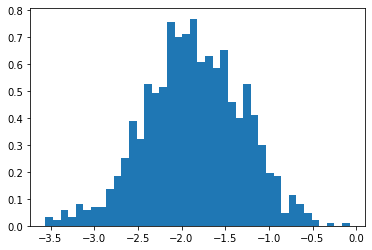

In [175]:
plt.hist(x.flatten().numpy(), bins=40, density=True)
plt.show()

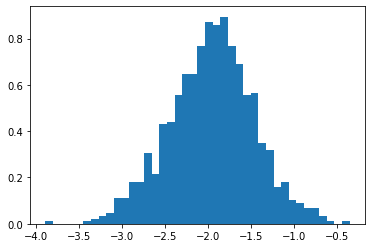

In [176]:
x = target.sample(torch.tensor([1000])).flatten().numpy()
plt.hist(x, bins=40, density=True)
plt.show()